In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw, rdFingerprintGenerator

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.svm import SVC

from collections import Counter

In [2]:
data_df = pd.read_csv('data_clean.csv', index_col=0)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2943 entries, 0 to 2942
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  2943 non-null   object 
 1   Ki                  2943 non-null   float64
 2   units               2943 non-null   object 
 3   pKi                 2943 non-null   float64
 4   smiles              2943 non-null   object 
 5   molecular_weight    2943 non-null   float64
 6   n_hba               2943 non-null   int64  
 7   n_hbd               2943 non-null   int64  
 8   logp                2943 non-null   float64
 9   passed              2943 non-null   bool   
dtypes: bool(1), float64(4), int64(2), object(3)
memory usage: 232.8+ KB


In [3]:
data_df.head(3)

,molecule_chembl_id,Ki,units,pKi,smiles,molecular_weight,n_hba,n_hbd,logp,passed
0,CHEMBL132806,57.0,nM,7.24,CC(C)CCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4...,429.191323,9,1,3.9613,True
1,CHEMBL336217,42.0,nM,7.38,CC(C)CCn1cc2c(nc(NC(=O)Cc3cccc4ccccc34)n3nc(-c...,479.206973,9,1,5.1145,True
2,CHEMBL134566,60.0,nM,7.22,O=C(Cc1ccccc1)Nc1nc2nn(CCCc3ccccc3)cc2c2nc(-c3...,477.191323,9,1,4.5480,True


In [4]:
cuts = pd.cut(data_df['pKi'], bins=3).value_counts()
cuts

pKi
(6.107, 8.213]    1701
(3.994, 6.107]     812
(8.213, 10.32]     430
Name: count, dtype: int64

In [5]:
# limit = cuts.index[2].left
# limit
limit = (data_df['pKi'].max() + data_df['pKi'].min()) / 2
limit

np.float64(7.16)

In [6]:
kolone = list(data_df.columns)
kolone

['molecule_chembl_id',
 'Ki',
 'units',
 'pKi',
 'smiles',
 'molecular_weight',
 'n_hba',
 'n_hbd',
 'logp',
 'passed']

In [7]:
kolone = ['molecule_chembl_id', 'Ki', 'units', 'pKi', 'smiles']
data_df = data_df[kolone]
data_df.reset_index(drop=True, inplace=True)
data_df.head()

,molecule_chembl_id,Ki,units,pKi,smiles
0,CHEMBL132806,57.0,nM,7.24,CC(C)CCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4...
1,CHEMBL336217,42.0,nM,7.38,CC(C)CCn1cc2c(nc(NC(=O)Cc3cccc4ccccc34)n3nc(-c...
2,CHEMBL134566,60.0,nM,7.22,O=C(Cc1ccccc1)Nc1nc2nn(CCCc3ccccc3)cc2c2nc(-c3...
3,CHEMBL435022,38.0,nM,7.42,CC(C)CCn1cc2c(nc(NC(=O)COc3ccccc3)n3nc(-c4ccco...
4,CHEMBL341376,423.0,nM,6.37,Cn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4)nc23)n1


In [8]:
def is_active(value):
    if value >= limit:
        return 1.0
    else:
        return 0.0

In [9]:
data_df['active'] = data_df['pKi'].apply(is_active)

In [10]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2943 entries, 0 to 2942
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  2943 non-null   object 
 1   Ki                  2943 non-null   float64
 2   units               2943 non-null   object 
 3   pKi                 2943 non-null   float64
 4   smiles              2943 non-null   object 
 5   active              2943 non-null   float64
dtypes: float64(3), object(3)
memory usage: 138.1+ KB


In [11]:
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=2048)

In [12]:
data_df['morgan'] = data_df['smiles'].apply(lambda smiles: morgan_gen.GetFingerprintAsNumPy(Chem.MolFromSmiles(smiles)))

In [13]:
data_df.head()

,molecule_chembl_id,Ki,units,pKi,smiles,active,morgan
0,CHEMBL132806,57.0,nM,7.24,CC(C)CCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4...,1.0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL336217,42.0,nM,7.38,CC(C)CCn1cc2c(nc(NC(=O)Cc3cccc4ccccc34)n3nc(-c...,1.0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL134566,60.0,nM,7.22,O=C(Cc1ccccc1)Nc1nc2nn(CCCc3ccccc3)cc2c2nc(-c3...,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL435022,38.0,nM,7.42,CC(C)CCn1cc2c(nc(NC(=O)COc3ccccc3)n3nc(-c4ccco...,1.0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CHEMBL341376,423.0,nM,6.37,Cn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4)nc23)n1,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [14]:
X_sve = np.stack(data_df['morgan'])
X_sve

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [15]:
y_sve = data_df['active'].to_numpy()
y_sve

array([1., 1., 1., ..., 0., 1., 0.])

In [16]:
smiles_sve = data_df['smiles'].to_numpy()

In [17]:
X_1, X_test, y_1, y_test, smiles_1, smiles_test = train_test_split(X_sve, y_sve, smiles_sve, test_size=0.2, random_state=42)

In [18]:
X_train, X_val, y_train, y_val, smiles_train, smiles_val = train_test_split(X_1, y_1, smiles_1, test_size=0.2, random_state=42)

In [19]:
X_train.shape, X_val.shape, X_test.shape

((1883, 2048), (471, 2048), (589, 2048))

In [20]:
y_train.shape, y_val.shape, y_test.shape

((1883,), (471,), (589,))

In [21]:
smiles_train.shape, smiles_val.shape, smiles_test.shape

((1883,), (471,), (589,))

In [22]:
forest_clf = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42, n_jobs=-1)

In [23]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=42)

<BarContainer object of 100 artists>

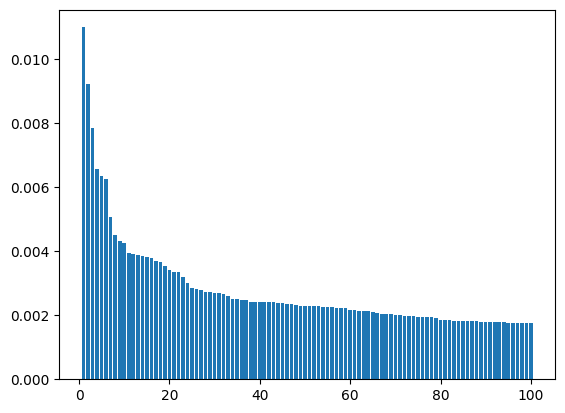

In [24]:
plt.bar(np.arange(1, 101), sorted(forest_clf.feature_importances_, reverse=True)[:100])

In [25]:
indices = np.argsort(forest_clf.feature_importances_)[-3:]
forest_clf.feature_importances_[indices]

array([0.00785859, 0.00923077, 0.01099498])

In [26]:
indices

array([ 121, 1171, 1457])

In [27]:
top_3 = sorted(np.argsort(forest_clf.feature_importances_)[-3:], key=lambda x: forest_clf.feature_importances_[x], reverse=True)
forest_clf.feature_importances_[top_3]

array([0.01099498, 0.00923077, 0.00785859])

In [28]:
top_3

[np.int64(1457), np.int64(1171), np.int64(121)]

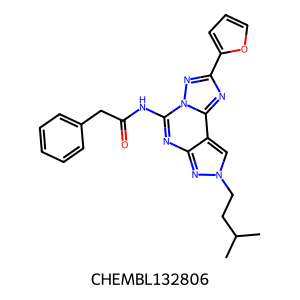

In [29]:
proba = Chem.MolFromSmiles(data_df['smiles'][data_df['active'] == 1.0].iloc[0])
Draw.MolToImage(proba, legend=data_df['molecule_chembl_id'][data_df['active'] == 1.0].iloc[0])

In [30]:
def get_info(mol):
    info = rdFingerprintGenerator.AdditionalOutput()
    info.CollectBitInfoMap()
    morgan_gen.GetFingerprintAsNumPy(mol, additionalOutput=info)
    return info.GetBitInfoMap()

In [31]:
info = get_info(proba)

In [32]:
for ind in top_3:
    print(ind in info)

False
False
True


In [33]:
info

{1: ((1, 0),),
 32: ((17, 3),),
 41: ((12, 1),),
 80: ((3, 0), (4, 0), (14, 0)),
 89: ((12, 3),),
 97: ((11, 3),),
 121: ((24, 1),),
 157: ((10, 1),),
 182: ((16, 3),),
 198: ((3, 3),),
 204: ((22, 2),),
 283: ((0, 1), (2, 1)),
 294: ((24, 3),),
 325: ((14, 1),),
 378: ((9, 0), (22, 0), (29, 0), (31, 0)),
 389: ((18, 2),),
 391: ((4, 3),),
 412: ((21, 1),),
 424: ((23, 2),),
 464: ((6, 1),),
 474: ((26, 2),),
 506: ((23, 3),),
 520: ((6, 3),),
 538: ((26, 3),),
 566: ((11, 2),),
 600: ((8, 1),),
 650: ((13, 0),),
 656: ((28, 0),),
 715: ((15, 3),),
 730: ((14, 2),),
 732: ((29, 3),),
 739: ((3, 1),),
 743: ((10, 3),),
 747: ((5, 1),),
 749: ((7, 3),),
 757: ((3, 2),),
 787: ((27, 1),),
 788: ((6, 2),),
 807: ((12, 0),),
 818: ((31, 3),),
 837: ((5, 2),),
 879: ((9, 2),),
 913: ((15, 2),),
 935: ((5, 0), (21, 0)),
 938: ((30, 3),),
 1013: ((7, 2),),
 1057: ((0, 0), (2, 0)),
 1066: ((16, 2), (20, 2)),
 1071: ((8, 2),),
 1088: ((17, 1), (18, 1), (19, 1), (26, 1)),
 1145: ((4, 1),),
 1152:

In [34]:
def get_fragment_for_bit(mol, bit_id):
    info = get_info(mol)
    if bit_id not in info:
        return None
    atom_indices = [atom[0] for atom in info[bit_id]]
    envir_radius = info[bit_id][0][1]
    fragment = Chem.FindAtomEnvironmentOfRadiusN(mol, radius=envir_radius, rootedAtAtom=atom_indices[0])
    submol = Chem.PathToSubmol(mol, path=fragment)
    return submol


In [35]:
no_rings = lambda smiles: ''.join((c.upper() if c in 'cons' else c) for c in smiles)

fragments = {k: Counter() for k in top_3}
for smiles in smiles_train:
    mol = Chem.MolFromSmiles(smiles)
    for bit in top_3:  # The three most important bits
        frag = get_fragment_for_bit(mol, bit)
        if frag is not None and frag.GetNumAtoms() > 0:
            frag = Chem.MolToSmiles(frag, canonical=True)
            fragments[bit][no_rings(frag)] += 1

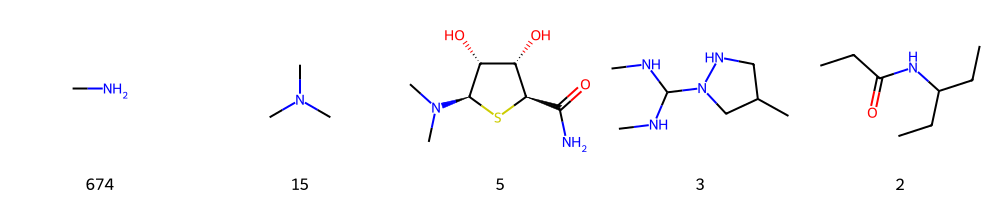

In [36]:
molecules = fragments[top_3[0]].most_common(5)
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol, _ in molecules], molsPerRow=5, subImgSize=(200, 200), legends=[str(c) for _, c in molecules])

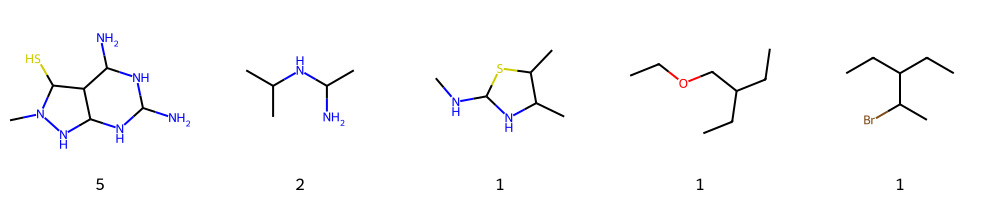

In [37]:
molecules = fragments[top_3[1]].most_common(5)
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol, _ in molecules], molsPerRow=5, subImgSize=(200, 200), legends=[str(c) for _, c in molecules])

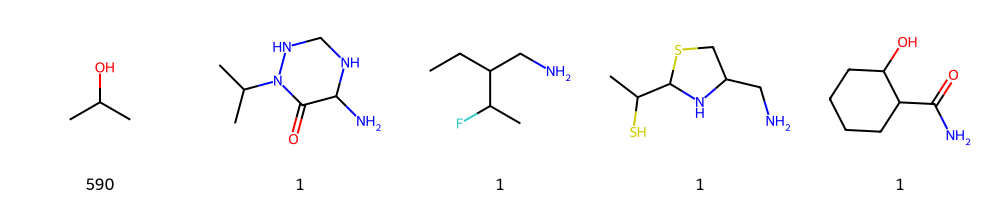

In [38]:
molecules = fragments[top_3[2]].most_common(5)
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol, _ in molecules], molsPerRow=5, subImgSize=(200, 200), legends=[str(c) for _, c in molecules])

In [39]:
y_pred = forest_clf.predict(X_test)

In [40]:
sum(y_pred == y_test) / len(y_pred) * 100

np.float64(80.81494057724957)

Some PCA analisys and clustering

In [41]:
scores = []
inertia = []
for num_cls in range(5, 50):
    cls = KMeans(n_clusters=num_cls, n_init=10, random_state=42)
    silh = silhouette_score(X_train, cls.fit_predict(X_train), random_state=42)
    scores.append([num_cls, silh])
    inertia.append((num_cls, cls.inertia_))


<Axes: xlabel='num_clusters', ylabel='scores'>

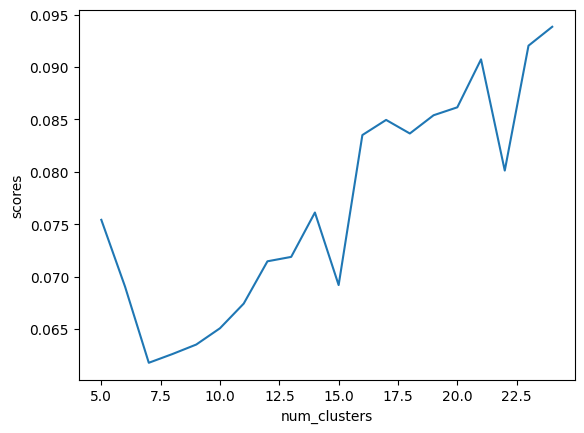

In [42]:
scores_df = pd.DataFrame(data=scores, columns=['num_clusters', 'scores'])
sns.lineplot(scores_df[:20], x='num_clusters', y='scores')

<Axes: xlabel='num_clusters', ylabel='inertia'>

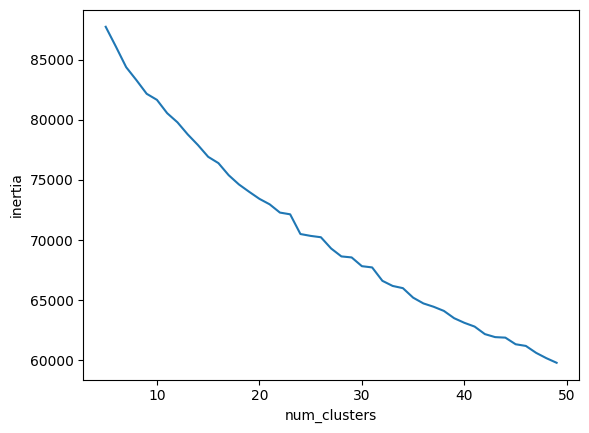

In [43]:
inertia_df = pd.DataFrame(data=inertia, columns=['num_clusters', 'inertia'])
sns.lineplot(inertia_df, x='num_clusters', y='inertia')

In [44]:
kmeans = KMeans(n_clusters=7, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_train, y_train)

In [45]:
tsne_pipe_2d = make_pipeline(
  PCA(n_components=50, random_state=42), TSNE(n_components=2, init='pca', random_state=42, n_jobs=-1)
)

In [46]:
X_embed = tsne_pipe_2d.fit_transform(X_train)

<Axes: >

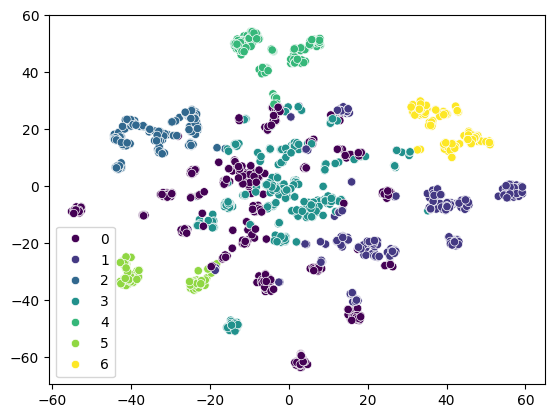

In [47]:
sns.scatterplot(x=X_embed[:, 0], y=X_embed[:, 1], hue=clusters, palette='viridis')

In [48]:
tsne_pipe_3d = make_pipeline(
    PCA(n_components=50, random_state=42),
    TSNE(n_components=3, init='pca', random_state=42, n_jobs=-1)
)

In [49]:
X_embed_3d = tsne_pipe_3d.fit_transform(X_train)

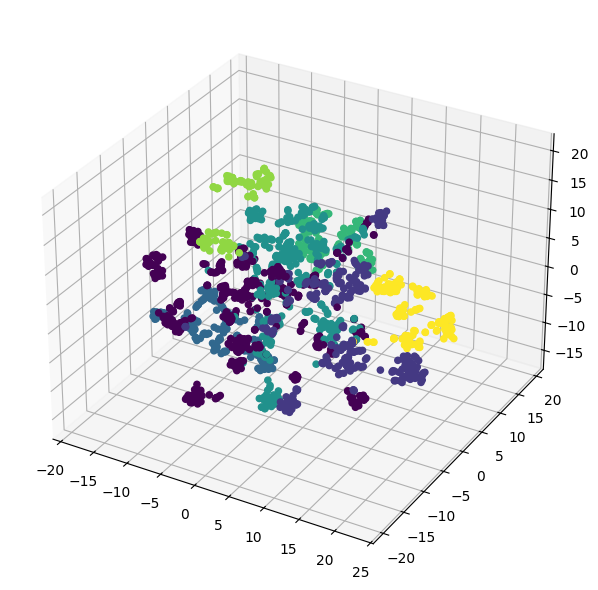

In [50]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.scatter(xs=X_embed_3d[:, 0], ys=X_embed_3d[:, 1], zs=X_embed_3d[:, 2], c=clusters, marker='o', depthshade=False, cmap='viridis')
plt.tight_layout()

<BarContainer object of 20 artists>

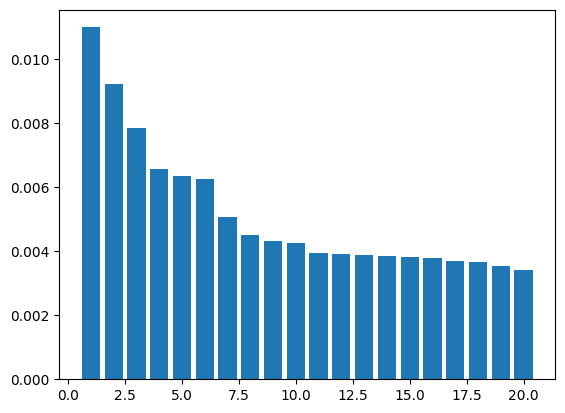

In [51]:
plt.bar(np.arange(1, 21), sorted(forest_clf.feature_importances_, reverse=True)[:20])

In [52]:
num = 6
important = np.argsort(forest_clf.feature_importances_)[-num:]
rest = np.argsort(forest_clf.feature_importances_)[:-num]
print(important, rest)
print(forest_clf.feature_importances_[important])

[ 708  656 1937  121 1171 1457] [  99 1252   66 ... 1256  883 1810]
[0.00625299 0.00634076 0.00656722 0.00785859 0.00923077 0.01099498]


In [53]:
def transform_with_pca(X):
    X_important = []
    X_rest = []
    for line in X:
        X_important.append(line[important])
        X_rest.append(line[rest])
    X_important = np.array(X_important)
    X_rest = np.array(X_rest)
    pca = PCA(n_components=5, random_state=42)
    X_pca = pca.fit_transform(X_rest)
    X_all = np.concat([X_important, X_pca], axis=1)
    print(X.shape, X_all.shape, X_important.shape, X_rest.shape)
    return X_all

In [54]:
X_train_pca = transform_with_pca(X_train)

(1883, 2048) (1883, 11) (1883, 6) (1883, 2042)


In [55]:

X_train_pca[100]

array([ 0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  3.07502807,  0.13794819,  0.13389906, -0.68132639,
       -0.0664504 ])

In [56]:
X_train_pca.shape

(1883, 11)

In [57]:
pca_forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, criterion='entropy')

In [58]:
pca_forest.fit(X_train_pca, y_train)

RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=42)

In [59]:
X_test_pca = transform_with_pca(X_test)

(589, 2048) (589, 11) (589, 6) (589, 2042)


In [60]:
y_pca_predict = pca_forest.predict(X_test_pca)

In [61]:
sum(y_test == y_pca_predict) / len(y_test) * 100

np.float64(63.1578947368421)

In [62]:
sum(y_pca_predict == 1), sum(y_test == 1)

(np.int64(221), np.int64(214))

In [63]:
sum(y_test == 1) / len(y_test) * 100

np.float64(36.33276740237691)

In [64]:
sum(y_train == 1) / len(y_train) * 100

np.float64(41.051513542219865)

In [65]:
sum(y_val == 1) / len(y_val) * 100

np.float64(40.12738853503185)

In [66]:
confusion_matrix(y_test, y_pca_predict)

array([[263, 112],
       [105, 109]])

In [67]:
confusion_matrix(y_test, y_pred)

array([[314,  61],
       [ 52, 162]])

In [68]:
svc_clf = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
svc_clf.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [69]:
y_pred_clf = svc_clf.predict(X_test)

In [70]:
sum(y_test == y_pred_clf) / len(y_test) * 100

np.float64(79.79626485568761)

In [71]:
confusion_matrix(y_test, y_pred_clf)

array([[317,  58],
       [ 61, 153]])

In [72]:
svc_pca = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
svc_pca.fit(X_train_pca, y_train)

SVC(probability=True, random_state=42)

In [73]:
y_pred_svc_pca = svc_pca.predict(X_test_pca)

In [74]:
sum(y_pred_svc_pca == y_test) / len(y_test) * 100 

np.float64(65.36502546689303)

In [75]:
confusion_matrix(y_test, y_pred_svc_pca)

array([[284,  91],
       [113, 101]])

In [76]:
print('asasa')

asasa
